In [1]:
import sys
import numpy as np
sys.path.append('..')
from Comms_System import Comms_System
from train_decision_making import train_DM_model
#from DE_minibatch import DE
from DE import DE
from objective_functions import MSE
from objective_functions import crossEntropy
from objective_functions import crossEntropyPytorch
from Network import NeuralNetwork
import matplotlib.pyplot as plt
import scipy.stats
from objective_functions import stablesoftmax as softmax

# Train Model

In [18]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 1334
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
noise_level = 2
# Automatic test
decisions, _, _, _, downsampled = CS.test_CS(noise_level=noise_level, v=False)

X = np.array(downsampled, ndmin=2).T
y = symbol_seq
classes = np.array(symbol_set)
num_classes = len(classes)
sizes = [1, 8, 4]
sizes[-1] = num_classes

# Makes a dictionary that maps a number to each symbol e.g. 3: 0
class_idx = {v: i for i, v in enumerate(classes)}

# Maps class indexes to each value in targets
y = np.array([class_idx[v] for v in y])

# Converts to one-hot-encoded
y = np.eye(num_classes)[y]

# split train-test
splitlen = int(X.shape[0] * 0.75)
Xtrain, ytrain = X[:splitlen], y[:splitlen]
Xtest, ytest = X[splitlen:], y[splitlen:]

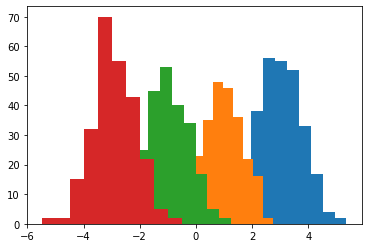

In [19]:
# Inspect symbol distribution in training (downsampled) data

for symbol in symbol_set:

    idx_ = symbol_seq[:splitlen] == symbol
    plt.hist(Xtrain[idx_])

1: Test Cost Falling  0.41622456135300817
3: Test Cost Falling  0.38666715092308435
4: Test Cost Falling  0.2482922722691408
6: Test Cost Falling  0.1692342618951244
12: Test Cost Falling  0.06475462762139332
17: Test Cost Falling  0.062159723131490714
18: Test Cost Falling  0.035608292988295494
20: Test Cost Falling  0.008342540375123319
23: Test Cost Falling  0.003221464967456401
25: Test Cost Falling  0.001591510783356782
26: Test Cost Falling  2.4881095101845755e-05
27: Test Cost Falling  1.9435461259535022e-09
29: Test Cost Falling  -1.1102230246251561e-15
Optimal number of iterations: 29
Best error: -1.1102230246251561e-15
Error at stop: -1.1102230246251561e-15


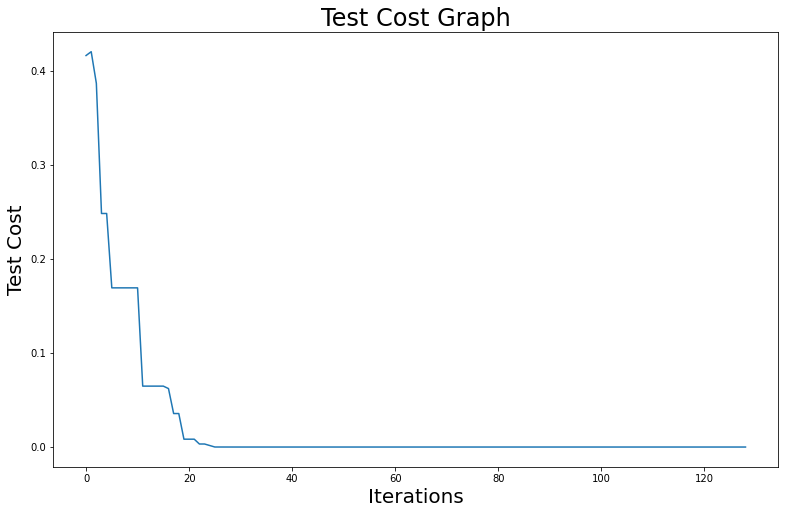

In [10]:
optimizer = 'DE'
early_stop = True

if optimizer == 'DE':
    D = DE(objective_function=crossEntropy, sizes=sizes, pop_size=50, F=0.55, cr=0.85,
           X=Xtrain, y=ytrain, Xtest=Xtest, ytest=ytest, type='classification', afunc='relu')
    
    if early_stop:
        best_agent = D.early_stop_training(patience=100)
    else:
        best_agent = D.evolution(num_epochs=200, verbose=True, print_epoch=500)
        D.evaluate()
    
elif optimizer == 'BP':
    NN = NeuralNetwork(sizes=sizes, afunc='relu')
    NN.train_loop(Xtrain, ytrain, Xtest, ytest, epochs=1000, batch_size=Xtrain.shape[0], 
                  cost=True, acc=True, plot=True)
    best_agent = NN

# Prediction Accuracy

In [11]:
# Get predictions
predictions = D.best_agent.feedforward(Xtest).argmax(axis=1)
true = ytest.argmax(axis=1)

# Convert back to symbols
predicted_symbols = classes[predictions]
true_values = classes[true]
# print(predicted_symbols, true_values)
correct_preds = np.equal(true_values, predicted_symbols)
print("Accuracy: ", (sum(correct_preds) / len(true_values)) * 100, "%")

Accuracy:  100.0 %


# Error Rate

In [12]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)

In [15]:
for i in range(10):

    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
    sigma = 0

    decisions, NN_decisions, _, _, _ = CS.test_CS(noise_level=sigma, dec_model=D.best_agent, v=False)
    #X = np.array(downsampled, ndmin=2).T

    print('Euclidean Distance Error Rate: {}%'.format((CS.evaluate(decisions)[1]*100).round(2)))
    print('Neural Net Error Rate: {}%'.format((CS.evaluate(NN_decisions)[1]*100).round(2)))

Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%
Euclidean Distance Error Rate: 0.0%
Neural Net Error Rate: 0.0%


----

# How to retrain automatically

In [ ]:
train = False
if train:
    D = train_DM_model(sizes=[1,8,4], num_symbols=1000, epochs=2001)

In [ ]:
# Evaluate
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
noise_level = 1

decisions, _ , _, downsampled = CS.test_CS(noise_level=noise_level, v=False)
X = np.array(downsampled, ndmin=2).T
classes = np.array(symbol_set)
new_NN_decisions = classes[D.best_agent.feedforward(X).argmax(axis=1)]

print('Euclidean Distance Error Rate: {}%'.format((CS.evaluate(decisions)[1]*100).round(2)))
print('Neural Net Error Rate: {}%'.format((CS.evaluate(new_NN_decisions)[1]*100).round(2)))

# Does model perform better? Then save the weights

In [ ]:
save_weights = False

if save_weights:
    D.save_params('decision_making_weights_CE_new3', 'decision_making_biases_CE_new3')